In [1]:
import snowflake.connector
import logging
from os import environ
from dotenv import load_dotenv
from statistics import mean
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
# Ativar mensagens de depuração
load_dotenv()
for logger_name in ['snowflake.connector', 'botocore']:
    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.DEBUG)
    handler = logging.StreamHandler()
    handler.setLevel(logging.DEBUG)
    logger.addHandler(handler)

conn = snowflake.connector.connect(
    user = environ['USER'],
    password = environ['PASSWORD'],
    account = environ['ACCOUNT'],
    warehouse = environ['WAREHOUSE'],
    database = environ['DATABASE'],
    schema = environ['SCHEMA']
)

Snowflake Connector for Python Version: 3.12.3, Python Version: 3.10.14, Platform: Windows-10-10.0.22631-SP0
connect
__config
Connecting to GLOBAL Snowflake domain
This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
use_numpy: False
initialized
REST API object was created: fa62087.us-east-2.aws.snowflakecomputing.com:443
authenticate
account=fa62087, user=PAULO_MAIA, database=POKER_PROD, schema=POKER, warehouse=REPORTING_POKER_WH, role=None, request_id=11fd81bb-9ac8-4b8e-a3a3-a6c582952b0c
body['data']: {'CLIENT_APP_ID': 'PythonConnector', 'CLIENT_APP_VERSION': '3.12.3', 'SVN_REVISION': None, 'ACCOUNT_NAME': 'fa62087', 'LOGIN_NAME': 'PAULO_MAIA', 'CLIENT_ENVIRONMENT': {'APPLICATION': 'PythonConnector', 'OS': 'Windows', 'OS_VERSION': 'Windows-10-10.0.22631-SP0', 'PYTHON_VERSION': '3.10.14', 'PYTHON_RUNTI

In [36]:
# SET THE PATH FOR THE MODEL AND ENCODER:
path_encoder = 'encoder.pkl'
path_model = 'model_v2.pkl'

# SET THE DATE TO BE ANALYZED: 
init_date = "'2024-01-01'"
end_date = "'2024-01-31'"

# FORMATING THE CELL AND GETTING THE DATA
with open('test_query.sql', 'r') as file:
    query = file.read()
    
formatted_query = query.format(init_date=init_date, end_date=end_date)

data = pd.read_sql_query(formatted_query, conn)

C:\Users\maiap\AppData\Local\Temp\ipykernel_52900\4057258757.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql_query(formatted_query, conn)
cursor
executing SQL/command
query: [WITH counts AS ( SELECT start_date_local, start_hour_local, COUNT(*) AS same_hou...]
binding: [WITH counts AS ( SELECT start_date_local, start_hour_local, COUNT(*) AS same_hou...] with input=[None], processed=[{}]
sequence counter: 11
Request id: 7843bdcb-4bb3-40bd-81bb-bbcfd8527671
running query [WITH counts AS ( SELECT start_date_local, start_hour_local, COUNT(*) AS same_hou...]
is_file_transfer: True
_cmd_query
serialize_to_dict() called
Cache Entry: (0, 1733273473024872, 0)
serialize_to_dict(): data to send to server {'entries': [{'id': 0, 'timestamp': 1733273473024872, 'priority': 0, 'context': {'base64Data': 'CObCIw=='}}]}
sql=[WI

In [8]:
import pickle
path_encoder = 'encoder.pkl'
path_model = 'model.pkl'
encoder = joblib.load(path_encoder)
#model = joblib.load(path_model)

with open(path_encoder, 'wb') as f:
    pickle.dump(model, f)
    
model.feature_names_in_

array(['LEVEL_REJECT', 'MTT_BLIND_UP_TIME_SEC', 'LATE_REGISTRATION_TIME',
       'EARLYBIRD', 'HAS_REBUY', 'HAS_ADDON', 'MTT_CUSTOMER_BUY_IN',
       'MTT_CUSTOMER_REBUY', 'MTT_CUSTOMER_ADDON', 'GTD',
       'BUYIN_GTD_RATE', 'SAME_HOUR_GAME', 'ONE_HOUR_WINDOW_GAME',
       'START_HOUR_LOCAL_0', 'START_HOUR_LOCAL_1', 'START_HOUR_LOCAL_2',
       'START_HOUR_LOCAL_3', 'START_HOUR_LOCAL_4', 'START_HOUR_LOCAL_5',
       'START_HOUR_LOCAL_6', 'START_HOUR_LOCAL_7', 'START_HOUR_LOCAL_8',
       'START_HOUR_LOCAL_9', 'START_HOUR_LOCAL_10', 'START_HOUR_LOCAL_11',
       'START_HOUR_LOCAL_12', 'START_HOUR_LOCAL_13',
       'START_HOUR_LOCAL_14', 'START_HOUR_LOCAL_15',
       'START_HOUR_LOCAL_16', 'START_HOUR_LOCAL_17',
       'START_HOUR_LOCAL_18', 'START_HOUR_LOCAL_19',
       'START_HOUR_LOCAL_20', 'START_HOUR_LOCAL_21',
       'START_HOUR_LOCAL_22', 'START_HOUR_LOCAL_23',
       'DAY_OF_WEEK_LOCAL_Domingo', 'DAY_OF_WEEK_LOCAL_Quarta',
       'DAY_OF_WEEK_LOCAL_Quinta', 'DAY_OF_WEEK_LOCAL_Se

In [37]:
# DATA TRANSFORMATION, ENCODING AND MODEL / ENCODING IMPORT
encoder = joblib.load(path_encoder)
model = joblib.load(path_model)

data_transform = data.drop(columns=['MATCH_ID', 'START_DATE_LOCAL'])
cat_columns = ['START_HOUR_LOCAL', 'DAY_OF_WEEK_LOCAL', 'KO_TYPE', 
               'MTT_POOL_ALLOCATION_DESCRIPTION', 'ESTRUTURA_BLINDS']
encoded_columns = encoder.fit_transform(data_transform[cat_columns])
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(cat_columns))
data_final = pd.concat([data_transform.drop(cat_columns, axis=1), encoded_df], axis=1)

# FITTING COLUMNS LIKE THE TRAINED MODEL
columns = list(model.feature_names_in_)
new_final = data_final.reindex(columns=columns, fill_value=0)

# EXECUTING THE MODEL
predictions = model.predict(new_final)

# COPY FROM ORIGINAL DF, OBTAINING THE RESULT, AND CREATION OF THE BOOL COLUMN "HAS_OVERLAY"
data_teste = data
data_teste['Predictions'] = predictions
data_teste['result_pred'] = data_teste['Predictions'] - data_teste['GTD']

# GENERAL INFORMATION FOR BOTH GRAPHS 
collected = data_teste['COLLECTED']
Predictions = data_teste['Predictions'] 
data_teste['result_pred'] = data_teste['Predictions'] - data_teste['GTD']
result_pred = data_teste['result_pred']
result = data_teste['MTT_RESULT']
erro_absoluto_por_ponto = np.abs(collected - Predictions)
erro_abs_ponto_result = np.abs(result - result_pred)

def check_overlay(dataframe):
    dataframe['has_overlay_pred'] = [True if value < 0 else False for value in dataframe['result_pred']]
    return dataframe
data_teste = check_overlay(data_teste)

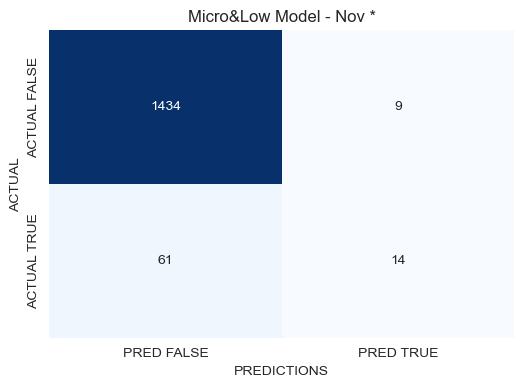

-27937.9

In [38]:
# CONFUSION MATRIX MES 9 USANDO HISTORY
y_true = data_teste['HAS_OVERLAY']
y_pred = data_teste['has_overlay_pred']
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["PRED FALSE", "PRED TRUE"], yticklabels=["ACTUAL FALSE", "ACTUAL TRUE"])
plt.xlabel("PREDICTIONS")
plt.ylabel("ACTUAL")
plt.title("Micro&Low Model - Nov *")
plt.show()

result_df = data.groupby('START_DATE_LOCAL').agg(actual_result=('MTT_RESULT', 'sum')).reset_index()
filtered_result_df = data[data['has_overlay_pred'] == False].groupby('START_DATE_LOCAL').agg(predicted_result=('MTT_RESULT', 'sum')).reset_index()
final_df = pd.merge(result_df, filtered_result_df, on='START_DATE_LOCAL', how='left')
final_df['dif'] = final_df['actual_result'] - final_df['predicted_result']
a = final_df['dif'].sum()
a

In [212]:
result_df = data.groupby('START_DATE_LOCAL').agg(actual_result=('MTT_RESULT', 'sum')).reset_index()
filtered_result_df = data[data['has_overlay_pred'] == False].groupby('START_DATE_LOCAL').agg(predicted_result=('MTT_RESULT', 'sum')).reset_index()
final_df = pd.merge(result_df, filtered_result_df, on='START_DATE_LOCAL', how='left')
final_df['dif'] = final_df['actual_result'] - final_df['predicted_result']
a = final_df['dif'].sum()
a

-1808.3300000000008

In [205]:
final_df

,START_DATE_LOCAL,actual_result,predicted_result,dif
0,2024-11-01,5339.86,5397.20,-57.34
1,2024-11-02,6832.10,6832.10,0.00
2,2024-11-03,9478.40,10096.50,-618.10
3,2024-11-04,4915.78,4918.36,-2.58
4,2024-11-05,11672.34,11780.74,-108.40
5,2024-11-06,6739.44,6864.58,-125.14
6,2024-11-07,11323.92,11323.92,0.00
7,2024-11-08,8925.46,8925.46,0.00
8,2024-11-09,5803.96,6061.92,-257.96
9,2024-11-10,6472.52,6945.02,-472.50


In [174]:
result_df

,START_DATE_LOCAL,actual_result
0,2024-08-01,11335.30
1,2024-08-02,8142.08
2,2024-08-03,8210.56
3,2024-08-04,6642.34
4,2024-08-05,7610.36
5,2024-08-06,9103.14
6,2024-08-07,10232.14
7,2024-08-08,10449.70
8,2024-08-09,8956.94
9,2024-08-10,5426.90


In [173]:
final_df

,START_DATE_LOCAL,actual_result,predicted_result,dif
0,2024-08-01,11335.30,11359.40,-24.10
1,2024-08-02,8142.08,8447.34,-305.26
2,2024-08-03,8210.56,8291.06,-80.50
3,2024-08-04,6642.34,7088.16,-445.82
4,2024-08-05,7610.36,7650.66,-40.30
5,2024-08-06,9103.14,9526.34,-423.20
6,2024-08-07,10232.14,10497.66,-265.52
7,2024-08-08,10449.70,10452.50,-2.80
8,2024-08-09,8956.94,8956.94,0.00
9,2024-08-10,5426.90,5937.30,-510.40


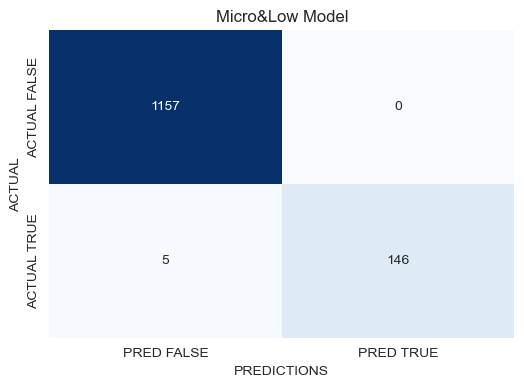

In [12]:
# CONFUSION MATRIX 
y_true = data_teste['HAS_OVERLAY']
y_pred = data_teste['has_overlay_pred']
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["PRED FALSE", "PRED TRUE"], yticklabels=["ACTUAL FALSE", "ACTUAL TRUE"])
plt.xlabel("PREDICTIONS")
plt.ylabel("ACTUAL")
plt.title("Micro&Low Model")
plt.show()

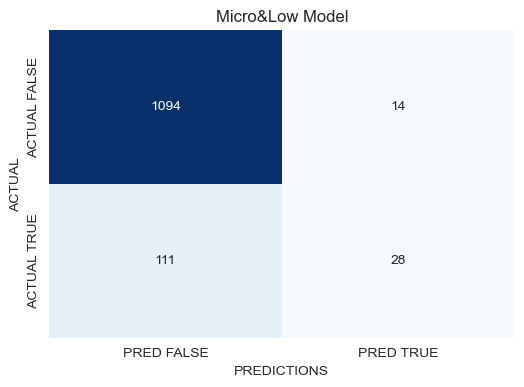

In [10]:
# CONFUSION MATRIX MES 10 2024 usando history
y_true = data_teste['HAS_OVERLAY']
y_pred = data_teste['has_overlay_pred']
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["PRED FALSE", "PRED TRUE"], yticklabels=["ACTUAL FALSE", "ACTUAL TRUE"])
plt.xlabel("PREDICTIONS")
plt.ylabel("ACTUAL")
plt.title("Micro&Low Model")
plt.show()

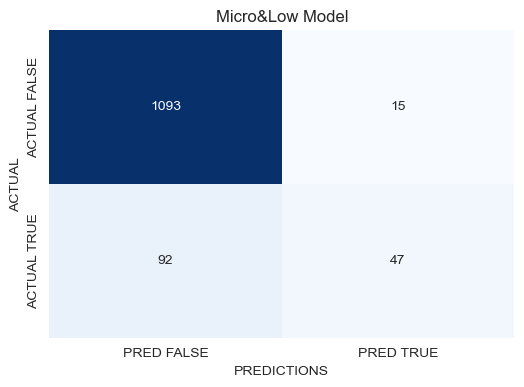

In [18]:
# CONFUSION MATRIX 
y_true = data_teste['HAS_OVERLAY']
y_pred = data_teste['has_overlay_pred']
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["PRED FALSE", "PRED TRUE"], yticklabels=["ACTUAL FALSE", "ACTUAL TRUE"])
plt.xlabel("PREDICTIONS")
plt.ylabel("ACTUAL")
plt.title("Micro&Low Model")
plt.show()

### Graphs about the collected 

In [ ]:
# Plot 1: ACTUAL VS PRED
plt.figure(figsize=(10,6))
plt.plot(collected, label='Actual', marker='o')
plt.plot(Predictions, label='Predictions', marker='x')
plt.title('Collected per point')
plt.xlabel('Point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Boxplot 
plt.figure(figsize=(10,6))
plt.boxplot(erro_absoluto_por_ponto, vert=True, showfliers=False)
plt.title('Abs error per point - Collected')
plt.xlabel('Abs Error')
plt.grid(True)
plt.show()

# Plot 3: Dynamic bar graph
fig = px.bar(data_teste, x=data_teste.index, y=['COLLECTED', 'Predictions'], 
             title='Comparison between predicted and actual',
             labels={'value': 'Collected values', 'index': 'Games'},
             barmode='group')

fig.show()

print(f'The mean absolute error is:{erro_absoluto_por_ponto.mean()}')
print(f'The median absolute error is:{erro_absoluto_por_ponto.median()}')


#### Graphs about the result

In [ ]:
# Plot 1: ACTUAL VS PRED
plt.figure(figsize=(10,6))
plt.plot(result, label='Actual', marker='o')
plt.plot(result_pred, label='Predictions', marker='x')
plt.title('Results per points')
plt.xlabel('Points')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Boxplot 
plt.figure(figsize=(10,6))
plt.boxplot(erro_abs_ponto_result, vert=True, showfliers=False)
plt.title('Abs Error per point - Results')
plt.xlabel('Abs error')
plt.grid(True)
plt.show()

# Plot 3: Dynamic bar graph
fig = px.bar(data_teste, x=data_teste.index, y=['MTT_RESULT', 'result_pred'], 
             title='Comparison between predicted and actual - Results',
             labels={'value': 'Result values', 'index': 'Games'},
             barmode='group')

fig.show()

# Cálculo da média e mediana do erro absoluto normalizado
print(f'The mean absolute error is:{erro_abs_ponto_result.mean()}')
print(f'The median absolute error is:{erro_abs_ponto_result.median()}')


## Profit calculation 

In [14]:
data_overlay = data_teste[(data_teste['HAS_OVERLAY'] == 1) & (data_teste['has_overlay_pred'] == 1)]
data_overlay

,MATCH_ID,START_DATE_LOCAL,START_HOUR_LOCAL,DAY_OF_WEEK_LOCAL,KO_TYPE,MTT_POOL_ALLOCATION_DESCRIPTION,LEVEL_REJECT,ESTRUTURA_BLINDS,MTT_BLIND_UP_TIME_SEC,LATE_REGISTRATION_TIME,...,MTT_RESULT,COLLECTED,NORMALIZED_MTT_RESULT,NORMALIZED_COLLECTED,BUYIN_GTD_RATE,SAME_HOUR_GAME,ONE_HOUR_WINDOW_GAME,Predictions,result_pred,has_overlay_pred
160,29521710,2024-11-05,18,Terça,Progressive KO,15% Flat,15,Turbo,720,10800.0,...,-20.40,1479.60,-1.700000,123.3,125.000000,4,8,1471.970337,-28.029663,True
194,29653865,2024-11-10,20,Domingo,Progressive KO,15% Flat,15,Turbo,600,9000.0,...,-456.00,5544.00,-41.454545,504.0,545.454545,2,7,5707.003906,-292.996094,True
228,29538150,2024-11-06,17,Quarta,Progressive KO,15% Flat,15,Turbo,720,10800.0,...,-98.16,1401.84,-44.618182,637.2,681.818182,1,3,1408.166992,-91.833008,True
340,29463279,2024-11-03,19,Domingo,Mystery Bounty,15% Flat,15,Hyper,600,9000.0,...,-27.20,1972.80,-3.400000,246.6,250.000000,2,5,1947.164917,-52.835083,True
346,29458213,2024-11-03,20,Domingo,Progressive KO,15% Flat,15,Turbo,600,9000.0,...,-149.10,5850.90,-13.554545,531.9,545.454545,2,7,5707.003906,-292.996094,True
390,29628080,2024-11-09,19,Sábado,Regular,15% Flat,15,Hyper - no ante,600,9000.0,...,-107.00,693.00,-10.700000,69.3,80.000000,2,6,306.248535,-493.751465,True
414,29462981,2024-11-03,15,Domingo,Mystery Bounty,10% Flat,15,Hyper,720,10800.0,...,-438.40,561.60,-73.066667,93.6,166.666667,3,7,873.573486,-126.426514,True


In [17]:
data_teste

,MATCH_ID,START_DATE_LOCAL,START_HOUR_LOCAL,DAY_OF_WEEK_LOCAL,KO_TYPE,MTT_POOL_ALLOCATION_DESCRIPTION,LEVEL_REJECT,ESTRUTURA_BLINDS,MTT_BLIND_UP_TIME_SEC,LATE_REGISTRATION_TIME,...,MTT_RESULT,COLLECTED,NORMALIZED_MTT_RESULT,NORMALIZED_COLLECTED,BUYIN_GTD_RATE,SAME_HOUR_GAME,ONE_HOUR_WINDOW_GAME,Predictions,result_pred,has_overlay_pred
0,29538913,2024-11-06,15,Quarta,KO,15% Flat,15,Turbo,600,9000.0,...,13.80,163.80,6.900000,81.9,75.000000,2,6,164.519409,14.519409,False
1,29538535,2024-11-06,22,Quarta,Regular,15% Flat,14,Hyper,420,5880.0,...,430.00,2430.00,143.333333,810.0,666.666667,2,9,2647.628906,647.628906,False
2,29539307,2024-11-06,22,Quarta,Regular,15% Flat,15,Turbo - no ante,300,4500.0,...,22.92,52.92,38.200000,88.2,50.000000,2,9,42.733154,12.733154,False
3,29538422,2024-11-06,12,Quarta,Regular,15% Flat,15,Turbo,360,5400.0,...,77.46,377.46,129.100000,629.1,500.000000,2,8,370.558899,70.558899,False
4,29539267,2024-11-07,4,Quinta,Regular,20% Flat,12,Hyper,300,3600.0,...,26.80,226.80,13.400000,113.4,100.000000,1,3,326.674622,126.674622,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,29628260,2024-11-09,13,Sábado,KO,15% Flat,14,Hyper,600,8400.0,...,-33.00,1467.00,-6.600000,293.4,300.000000,4,8,1574.033936,74.033936,False
468,29628040,2024-11-09,8,Sábado,Regular,20% Flat,13,Turbo,420,5460.0,...,62.70,362.70,62.700000,362.7,300.000000,2,4,359.070190,59.070190,False
469,29628428,2024-11-09,23,Sábado,Regular,15% Flat,13,Turbo,360,4680.0,...,348.24,948.24,435.300000,1185.3,750.000000,4,6,861.473816,261.473816,False
470,29628307,2024-11-09,14,Sábado,Regular,15% Flat,15,Turbo,480,7200.0,...,475.80,1675.80,475.800000,1675.8,1200.000000,2,8,1686.382202,486.382202,False


In [ ]:
data = data_teste

result_df = data.groupby('START_DATE_LOCAL').apply(lambda x: pd.Series({
    'total_overlay_actual': x.loc[x['HAS_OVERLAY'] == True, 'MTT_RESULT'].sum(),
    'total_overlay_pred': x.loc[(x['HAS_OVERLAY'] == True) & (x['has_overlay_pred'] == True), 'MTT_RESULT'].sum(),
    'profit_actual': x.loc[x['HAS_OVERLAY'] == False, 'MTT_RESULT'].sum(),
    'profit_pred': x.loc[(x['HAS_OVERLAY'] == False) & (x['has_overlay_pred'] == False), 'MTT_RESULT'].sum()
})).reset_index()

result_df['dif_overlay'] = result_df['total_overlay_actual'] - result_df['total_overlay_pred']
result_df['dif_profit'] = result_df['profit_actual'] - result_df['profit_pred']
result_df['profit_dif_total'] = data[data['has_overlay_pred'] == False].groupby('START_DATE_LOCAL')['MTT_RESULT'].sum().reindex(result_df['START_DATE_LOCAL']).values


In [37]:
data[data['has_overlay_pred'] == True]

,MATCH_ID,START_DATE_LOCAL,START_HOUR_LOCAL,DAY_OF_WEEK_LOCAL,KO_TYPE,MTT_POOL_ALLOCATION_DESCRIPTION,LEVEL_REJECT,ESTRUTURA_BLINDS,MTT_BLIND_UP_TIME_SEC,LATE_REGISTRATION_TIME,...,MTT_RESULT,COLLECTED,NORMALIZED_MTT_RESULT,NORMALIZED_COLLECTED,BUYIN_GTD_RATE,SAME_HOUR_GAME,ONE_HOUR_WINDOW_GAME,Predictions,result_pred,has_overlay_pred
14,29565660,2024-11-07,13,Quinta,KO,15% Flat,14,Hyper,600,8400.0,...,335.00,1935.00,67.000000,387.0,320.000000,3,7,1562.689453,-37.310547,True
20,29594716,2024-11-08,16,Sexta,Progressive KO,20% Flat,15,Turbo,600,9000.0,...,87.90,387.90,87.900000,387.9,300.000000,3,6,295.377563,-4.622437,True
77,29486089,2024-11-04,17,Segunda,Regular,15% Flat,15,Turbo,720,10800.0,...,701.90,10701.90,63.809091,972.9,909.090909,2,4,9796.007812,-203.992188,True
160,29521710,2024-11-05,18,Terça,Progressive KO,15% Flat,15,Turbo,720,10800.0,...,-20.40,1479.60,-1.700000,123.3,125.000000,4,8,1471.970337,-28.029663,True
194,29653865,2024-11-10,20,Domingo,Progressive KO,15% Flat,15,Turbo,600,9000.0,...,-456.00,5544.00,-41.454545,504.0,545.454545,2,7,5707.003906,-292.996094,True
228,29538150,2024-11-06,17,Quarta,Progressive KO,15% Flat,15,Turbo,720,10800.0,...,-98.16,1401.84,-44.618182,637.2,681.818182,1,3,1408.166992,-91.833008,True
232,29565775,2024-11-07,15,Quinta,KO,15% Flat,13,Turbo,600,7800.0,...,60.60,210.60,30.300000,105.3,75.000000,1,5,145.335693,-4.664307,True
280,29659100,2024-11-10,19,Domingo,Mystery Bounty,15% Flat,15,Hyper,600,9000.0,...,44.80,2044.80,5.600000,255.6,250.000000,2,4,1966.847412,-33.152588,True
297,29592951,2024-11-08,15,Sexta,Regular,15% Flat,15,Hyper,600,9000.0,...,1304.60,5304.60,434.866667,1768.2,1333.333333,1,5,3765.437744,-234.562256,True
319,29596182,2024-11-08,13,Sexta,KO,15% Flat,14,Hyper,600,8400.0,...,146.00,1746.00,29.200000,349.2,320.000000,4,7,1492.928223,-107.071777,True


In [124]:
result_df = data.groupby('START_DATE_LOCAL').agg(actual_result=('MTT_RESULT', 'sum')).reset_index()
filtered_result_df = data[data['has_overlay_pred'] == 0].groupby('START_DATE_LOCAL').agg(predicted_result=('MTT_RESULT', 'sum')).reset_index()
final_df = pd.merge(result_df, filtered_result_df, on='START_DATE_LOCAL', how='left')
final_df['dif'] = final_df['actual_result'] - final_df['predicted_result']
a = final_df['dif'].sum()
a

-8563.199999999997

In [20]:
final_df

,START_DATE_LOCAL,actual_result,predicted_result,dif
0,2024-01-01,7225.52,7225.52,0.00
1,2024-01-02,19677.40,19676.38,1.02
2,2024-01-03,24549.92,18385.72,6164.20
3,2024-01-04,20612.78,20593.48,19.30
4,2024-01-05,16832.96,16832.96,0.00
5,2024-01-06,14608.36,14608.36,0.00
6,2024-01-07,20962.70,20962.70,0.00
7,2024-01-08,14067.46,14067.46,0.00
8,2024-01-09,14678.36,14655.48,22.88
9,2024-01-10,19143.02,19143.52,-0.50


In [34]:
a = final_df['dif'].sum()
a

-7254.440000000001

In [9]:
final_df['dif'] = final_df['actual_result'] - final_df['predicted_result']
final_df

,START_DATE_LOCAL,actual_result,predicted_result,dif
0,2024-10-01,9860.00,10520.92,-660.92
1,2024-10-02,7759.29,7782.73,-23.44
2,2024-10-03,5939.18,6027.18,-88.00
3,2024-10-04,7256.74,7581.81,-325.07
4,2024-10-05,2103.90,2996.06,-892.16
5,2024-10-06,-340.00,3845.36,-4185.36
6,2024-10-07,5047.98,5354.78,-306.80
7,2024-10-08,4110.35,4311.67,-201.32
8,2024-10-09,4672.96,5323.48,-650.52
9,2024-10-10,5944.51,6908.80,-964.29


In [13]:
a = final_df['dif'].sum()
a

-12943.82

In [12]:
a = final_df['dif'].sum()
a

-9115.239999999998

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import pickle
import cachetools

# SET THE PATH FOR THE MODEL AND ENCODER:
path_encoder = '../new_model/encoder.pkl'
path_model = '../new_model/model.pkl'

encoder = joblib.load(path_encoder)
model = joblib.load(path_model)

# Título do App
st.title(':spades: :blue[Modelo de regressão MTT] :spades:')

data = st.file_uploader("Insira seu csv aqui")
data = pd.read_csv(data)
data_transform = data.drop(columns=['MATCH_ID', 'START_DATE_LOCAL'])
cat_columns = ['START_HOUR_LOCAL', 'DAY_OF_WEEK_LOCAL', 'KO_TYPE',
               'MTT_POOL_ALLOCATION_DESCRIPTION', 'ESTRUTURA_BLINDS']
encoded_columns = encoder.fit_transform(data_transform[cat_columns])
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(cat_columns))
data_final = pd.concat([data_transform.drop(cat_columns, axis=1), encoded_df], axis=1)

# FITTING COLUMNS LIKE THE TRAINED MODEL
columns = list(model.feature_names_in_)
new_final = data_final.reindex(columns=columns, fill_value=0)

# EXECUTING THE MODEL
predictions = model.predict(new_final)


# COPY FROM ORIGINAL DF, OBTAINING THE RESULT, AND CREATION OF THE BOOL COLUMN "HAS_OVERLAY"
data_teste = data
data_teste['Predictions'] = predictions
data_teste['result_pred'] = data_teste['Predictions'] - data_teste['GTD']


def check_overlay(dataframe):
    dataframe['has_overlay_pred'] = [True if value < 0 else False for value in dataframe['result_pred']]
    return dataframe


data_teste = check_overlay(data_teste)

@st.cache_data
def convert_df(df):
   return data_teste.to_csv(index=False).encode('utf-8')


csv = convert_df(data_teste)



# Botao para aplicaco do modelo
st.download_button(
   "Press to Download",
   csv,
   "file.csv",
   "text/csv",
   key='download-csv'
)
st.subheader("", divider='blue')

############################################### EXPANDER 1 ###############################################################################

######################################################### EXPANDER 2 #######################################################################


#############################################################################################################################################
